# Machine Learning Using NYC 311 and Census Data

### Question: Can a combination of census data and NYC/311 data allow for a model that can predict anything about the makeup of its neighborhoods?

### Answer:  Not so far...
### Better Answer:  It's Complicated...

![alt text](hmm.png "Title")

# New York - So Nice, They Named It Twice

Can I predict the characteristics of a NYC zip code using machine learning models?

1. Can I predict whether a zip code's population will increase or decrease using a classification model?
2. Can I predict a zip code's median income using a linear reqression model?

# Importing & Cleaning Up the Data


# Lessons Learned About Working With Large Government Datasets


## Census Data
Census data is distributed, broken up into chunks and there is lots of it.  Ideally, the data the government makes available can be imported into a database, joined and then extracted.  For this project, the census data was collected in a csv file and pulled from github.  I collected a zip code's 2010 population, 2015 population, median age, median income, percentage with high school degree's or higher, and percentage living in poverty.

https://factfinder.census.gov/faces/nav/jsf/pages/community_facts.xhtml


## 311 Data & NYC Open Data Website
NYC collects data for all of its city agencies and 311 service requests.  The 311 database is massive.  A collection of 5 years worth of service requests is about 10GB of csv files.  For this project, it quickly became impractical to work with this data for the following reasons:

- The large datasets took a long time to load into SQL (never use the import wizard for this purpose).  
- Once it was loaded faster, I couldn't write a query statement optimized enough to run quickly against the datasets.  For example, attempting to count and aggregate service requests by zip code took a long time.
- As a result, adjustments to the queries took a long time to evaluate (much more than I had time for this project).


## Alternative Data
I opted to use a smaller dataset also available on the NYC Open Data website - NYC Restaurant Inspections Results.  This data contains restaurant cuisine, zipcode and grade (among other columns) and was loaded into SQL.  The raw data can be located directedly at the link below and is posted on my github.  This data was turned into a local SQL database.

https://opendata.cityofnewyork.us/
https://raw.githubusercontent.com/johnnymango/IS362stuff/master/DOHMH_New_York_City_Restaurant_Inspection_Results.csv



In [1]:
# import the modules needed for this analysis.

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
%matplotlib inline

## CSV Read From Github

In [2]:
# Import the zip code census data.  The data reads a csv pull from a github repo.
# Cleanup is required: columns are renamed and the zip codes are set as the index for later concatenation.

url = 'https://raw.githubusercontent.com/johnnymango/IS362stuff/master/nycdata.csv'
nycdata = pd.read_csv(url)
nycdata = nycdata.dropna()
nycdata.columns = ['zipcode', 'county', '2010pop', '2015pop', 'popchange', 'popsize', 'medAge', 'highed', 'medInc', 'povlevel', 'popresponse']
nycdata.set_index('zipcode', inplace=True)
nycdata.tail()

,county,2010pop,2015pop,popchange,popsize,medAge,highed,medInc,povlevel,popresponse
zipcode,,,,,,,,,,
11691,Queens,60035.0,63989.0,0.07,0.007,32.4,0.71,42023.0,0.23,increase
11692,Queens,18540.0,18955.0,0.02,0.002,35.6,0.74,42127.0,0.22,increase
11693,Queens,11916.0,11194.0,-0.06,0.001,40.6,0.83,53281.0,0.20,decrease
11694,Queens,20408.0,20773.0,0.02,0.002,45.1,0.88,75094.0,0.06,increase
11697,Queens,4079.0,4006.0,-0.02,0.000,44.7,0.97,93333.0,0.04,decrease


## SQL Read

In [3]:
# Connect to my NYC database on MYSQL containing a Restaurants table.
# The data is pulled from the DB and read in as dataframe.
# Weird character showed up in the import in the grade column. I stripped the characted to keep the data tidy.

df = pymysql.connect(host='localhost',  
                       port=3306,  
                       user='root',  
                       passwd='root',  
                       db='newyork',  
                       charset='utf8'
                    )
cur = df.cursor()

sql = """SELECT zip, cuisine, grade FROM nyc.restaurants"""
              
cur.execute(sql)
cur.close
df.close
restaurants = pd.read_sql(sql, df)
restaurants['grade'] = restaurants.grade.str.split('\r').str.get(0)
restaurants.columns =['zipcode', 'cuisine', 'grade']
restaurants.head()

,zipcode,cuisine,grade
0,11358,Korean,A
1,11205,Indian,A
2,10014,American,A
3,10018,CafÃ©/Coffee/Tea,A
4,11373,"Latin (Cuban, Dominican, Puerto Rican, South &...",A


In [4]:
# For my analysis, I counted the number of restaurants by zip code.
# The zip codes were assigned as the index - which is essential for the concatenation step later on.

restcounts = pd.DataFrame(restaurants['zipcode'].value_counts())
restcounts.columns = ['restcount']
restcounts.index.name = 'zipcode'
restcounts.head()

,restcount
zipcode,
10003,1506
10019,1319
10036,1242
10013,1097
10016,1069


# The Trouble with Zip Codes

- Zip codes are a convenient data element to pivot around since many things maps to it.
- The original 311 data was riddled with zip code errors and missing zips (the dataset size made cleaning this up a bit too prohibitive for the project).
- NYC zip codes are tricky.  Many zipcode are tied to mid-town office towers where the census data is just not applicable.

From a technical perspective, my zipcode indices were created as different types during the import and dataframe creation process.  This prevented the concatenation of the columns based on the zip code values.


In [5]:
type(nycdata.index)

pandas.indexes.numeric.Int64Index

In [6]:
type(restcounts.index)

pandas.indexes.base.Index

In [7]:
# This code makes the zipcode indices the same type making concat possible
nycdata.index = nycdata.index.map(str)
restcounts.index = restcounts.index.map(str)

# Adds the count of restaurants to the census data.  
result = pd.concat([nycdata, restcounts], axis=1, join='inner')
result.head()

,county,2010pop,2015pop,popchange,popsize,medAge,highed,medInc,povlevel,popresponse,restcount
10003,New York,56024.0,57112.0,0.02,0.007,32.1,0.97,98151.0,0.10,increase,1506
10019,New York,42870.0,38830.0,-0.09,0.004,39.2,0.94,94022.0,0.12,decrease,1319
10036,New York,24711.0,25799.0,0.04,0.003,37.0,0.95,75966.0,0.13,increase,1242
10013,New York,27700.0,27415.0,-0.01,0.003,36.9,0.81,96667.0,0.12,decrease,1097
10016,New York,54183.0,50641.0,-0.07,0.006,33.4,0.97,104826.0,0.10,decrease,1069


# Insights Into NYC

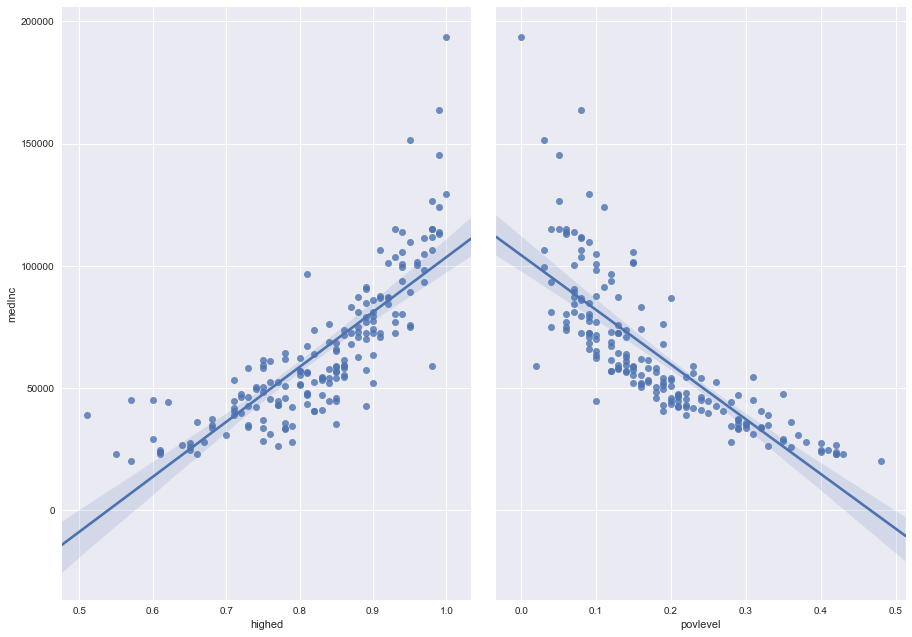

In [8]:
# Relationship beteween level of education, percentage of people living below poverty levey by a zip codes median income.

sns.pairplot(nycdata, x_vars=['highed', 'povlevel'], y_vars='medInc', size=9, 
             aspect= .7, kind='reg')

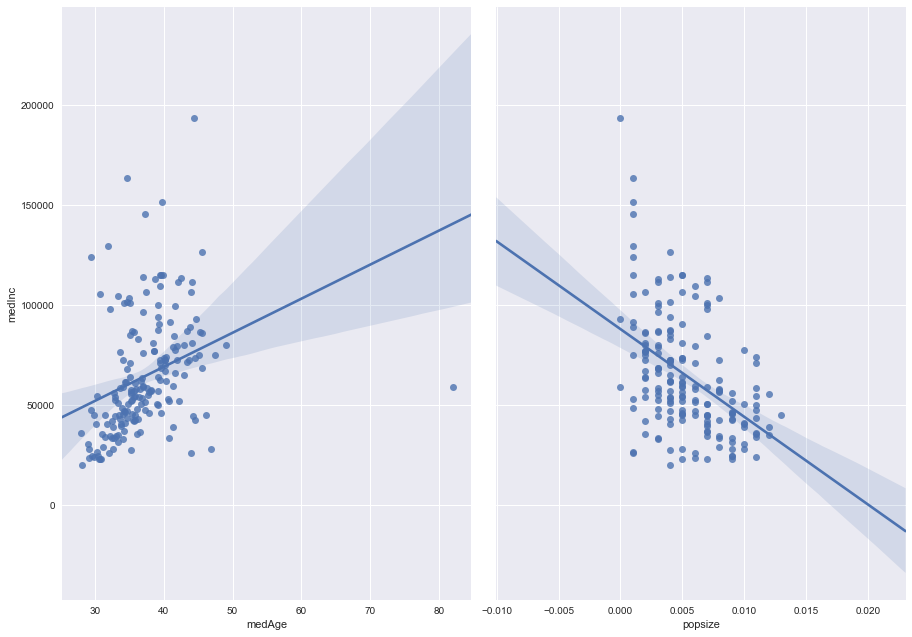

In [9]:
# Relationship of Median Age and the overall percentage of population against Median Income.

sns.pairplot(nycdata, x_vars=['medAge', 'popsize'], y_vars='medInc', size=9, 
             aspect= .7, kind='reg')

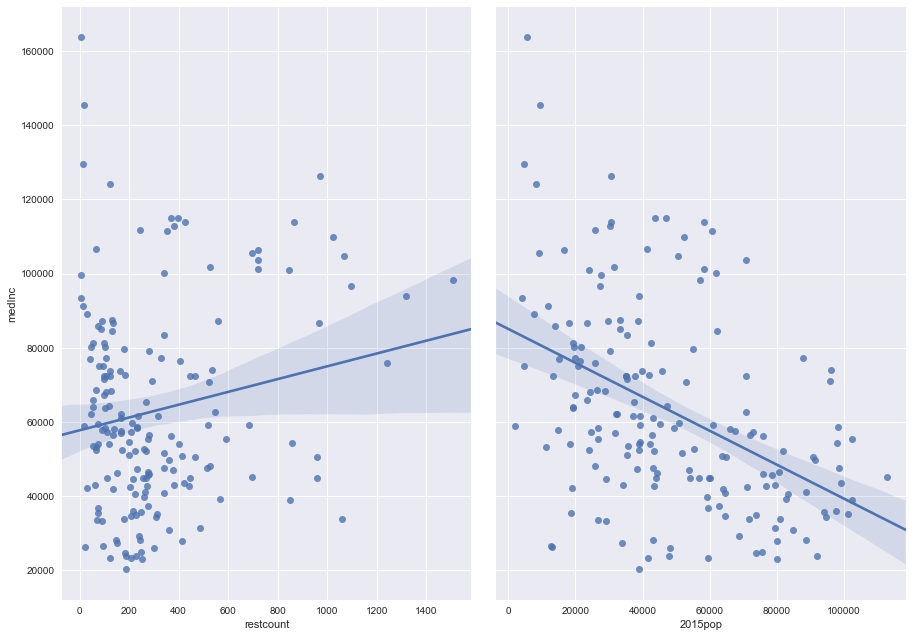

In [10]:
# Relationship of the Number of restaurants and the total populations against Median Income.
sns.pairplot(result, x_vars=['restcount', '2015pop'], y_vars='medInc', size=9, 
             aspect= .7, kind='reg')

<function matplotlib.pyplot.show>

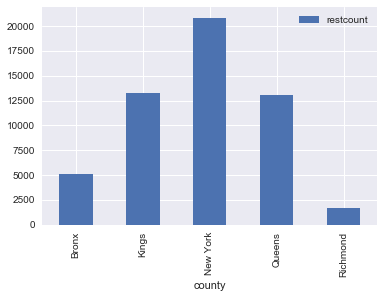

In [11]:
# Number of restaurants by county.  This can be further analyzed by normalizing for population.

df = result[['county', 'restcount']]
df = df.groupby(['county']).sum()
df.plot(kind = 'bar')
plt.show


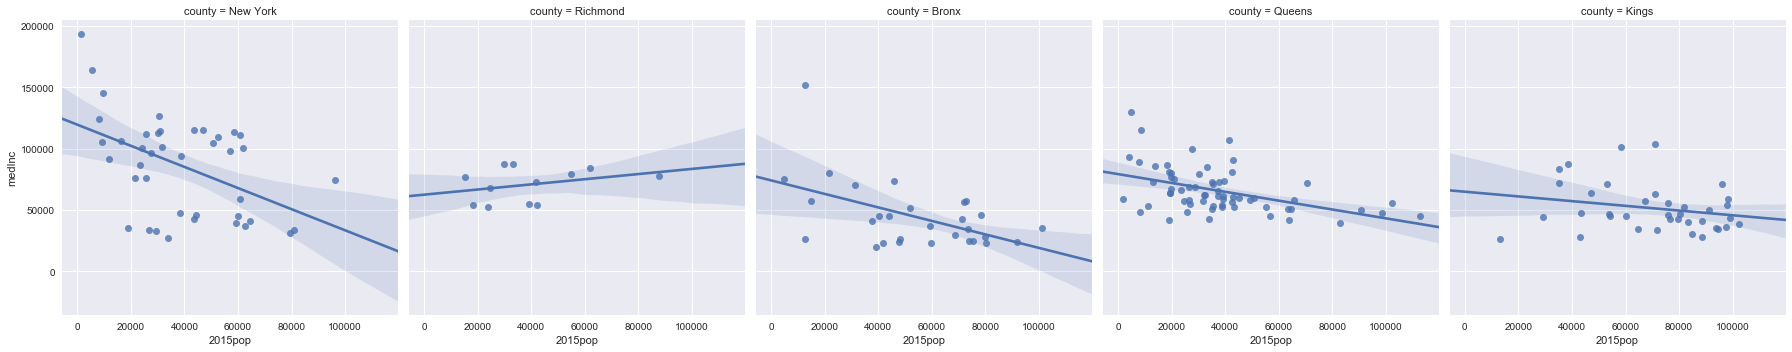

In [12]:
# Relationshp between a county's 2015 population and the median income of the zip county.

sns.lmplot(x='2015pop', y='medInc', col='county', data=nycdata)


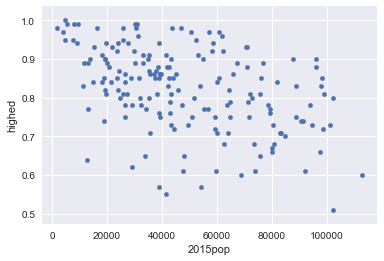

In [13]:
# Relationship of 2015 population to level of level of education.

nyc_scatter = result.plot.scatter(x='2015pop', y='highed')
plt.show()

# Building a Classification Model

With this insight, I wanted to predict if a zipcode's population would increase or decrease given some of its features.

In [14]:
# Creating the features matrix.

result['popresponse'].replace('decrease', 0, inplace=True)
result['popresponse'].replace('increase', 1, inplace=True)
result['popresponse'].replace('no change', 2, inplace=True)

X = result[['2015pop', 'popsize', 'medAge', 'highed', 'medInc', 'povlevel', 'restcount']]
X.head()

,2015pop,popsize,medAge,highed,medInc,povlevel,restcount
10003,57112.0,0.007,32.1,0.97,98151.0,0.10,1506
10019,38830.0,0.004,39.2,0.94,94022.0,0.12,1319
10036,25799.0,0.003,37.0,0.95,75966.0,0.13,1242
10013,27415.0,0.003,36.9,0.81,96667.0,0.12,1097
10016,50641.0,0.006,33.4,0.97,104826.0,0.10,1069


In [15]:
# Creating the response vector.  The predictions are will the zip code decrease (0), increase (1) or no change (2).

y = result['popresponse']
y.head()

10003    1
10019    0
10036    1
10013    0
10016    0
Name: popresponse, dtype: int64

In [16]:
# Train, Test, Split to create the training and testing datasets.

from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(132, 7)
(132,)
(44, 7)
(44,)


# Null Accuracy for Increasing Populations

Null accurracy is the accuracy that can be achieved by always predicting the most common response.

- Decreases = 21%
- Increases = 72%
- No Change = 7%

In [17]:
# First, we'll try logistic regression.

from sklearn.linear_model import LogisticRegression 
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [18]:
# The accuracy is only about 59%.

print (metrics.accuracy_score(y_test, y_pred))

0.636363636364


In [19]:
# Next, we'll try the K Nearest Neighbor.

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [20]:
# The accuracy of the K nearest neighbor model is about 66% with a k=5

print (metrics.accuracy_score(y_test, y_pred))

0.659090909091


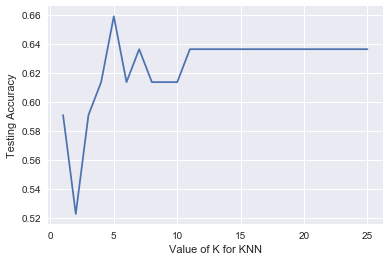

In [21]:
# Maybe a better k value will yield better results.  This code checks for accuracy scores for k values between 1-25.
# (Sourced from Kevin Markham's Machine Learning tutorial)



k_range = range(1, 26)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

k = 5 is the ideal k value.

# Conclusion About Classification Models to Predict Zip Code Pop Changes

My models are horrible at predicting whether a zipcodes population will increase, decrease or remain the same.  Null accurracy is a better predictor than the model.


# A Linear Regression model to predict the Median Income

In [22]:
# Create a new matrix with the features to be considered for the median income prediction.

X = result[['2015pop', 'popsize', 'medAge', 'highed', 'povlevel', 'restcount']]
X.head()

,2015pop,popsize,medAge,highed,povlevel,restcount
10003,57112.0,0.007,32.1,0.97,0.10,1506
10019,38830.0,0.004,39.2,0.94,0.12,1319
10036,25799.0,0.003,37.0,0.95,0.13,1242
10013,27415.0,0.003,36.9,0.81,0.12,1097
10016,50641.0,0.006,33.4,0.97,0.10,1069


In [23]:
# Create a y vector of median incomes.

y = result['medInc']
y.head()

10003     98151.0
10019     94022.0
10036     75966.0
10013     96667.0
10016    104826.0
Name: medInc, dtype: float64

In [24]:
# Train, Test, Split the data used for the linear regression model.

from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(132, 6)
(132,)
(44, 6)
(44,)


In [25]:
# Fit the data into the linear regression model.

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

# The LR Model Predicted the Median Income with an average error of 11,000 unit (dollars).  For example, it may have predicted 40K median income where the actual value was closer to 50K.

The model needs more work.  The median income error probably has less impact at the higher income ranges than the lower ones.

In [26]:
print (np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

10260.75454


# Conclusion

Linear Regression modeling to predict median income, poverty levels, level of education are probably can be more accurate (and useful) than classification models. By adding additional columns to the matrix that can be collected from government sources, the LR model may become more accurate.  Other possible data points that may have an impact of median income, or other vectors include the number of schools, the number of 311 service tickets, the number of 911 calls, the number of homes with internet service, etc.